# Titanic Survival Analysis

## This is an analysis of the Kaggle's competition Titanic Dataset, where we must predict whether a passenger would survive or not

# Data Dictionary
Variable&emsp;&emsp;Definition&emsp;&emsp;Key <br>
***
survival&emsp;&emsp;&nbsp;Survival&emsp;&emsp;&nbsp;&nbsp;0 = No, 1 = Yes <br>
pclass&emsp;&emsp;&emsp;Ticket class&emsp;1 = 1st, 2 = 2nd, 3 = 3rd <br>
sex&emsp;&emsp;&emsp;&emsp;&nbsp;Sex	<br>
Age&emsp;&emsp;&emsp;&emsp;Age in years	<br>
sibsp&emsp;&emsp;&nbsp;&emsp;# of siblings / spouses aboard the Titanic	<br>
parch&emsp;&emsp;&emsp;# of parents / children aboard the Titanic	<br>
ticket&emsp;&emsp;&emsp;Ticket number	<br>
fare&emsp;&emsp;&emsp;&nbsp;&nbsp;&nbsp;Passenger fare	<br>
cabin&emsp;&emsp;&emsp;Cabin number	<br>
embarked&emsp;Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton<br>

## Variable Notes

#### pclass: A proxy for socio-economic status (SES)<br>
1st = Upper
2nd = Middle
3rd = Lower<br>

__age__: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

#### sibsp: The dataset defines family relations in this way...<br>
__Sibling__ = brother, sister, stepbrother, stepsister<br>
__Spouse__ = husband, wife (mistresses and fiancés were ignored)<br>

#### parch: The dataset defines family relations in this way...<br>
__Parent__ = mother, father<br>
__Child__ = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("expand_frame_repr", False)  #setting pandas to show the columns without line break

### Let's us load the dataset and check the data before anything

In [2]:
train = pd.read_csv('train.csv',index_col='PassengerId')
test = pd.read_csv('test.csv',index_col='PassengerId')

print(train.head(),'\n\n')
print(train.describe(),'\n\n')
print(train.dtypes,'\n\n')


             Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
PassengerId                                                                                                                                           
1                   0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
2                   1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
3                   1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
4                   1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
5                   0       3                           Allen, Mr. William Henry    male  35.0

### Checking the first entries

In [3]:
print(test.head())

             Pclass                                          Name     Sex   Age  SibSp  Parch   Ticket     Fare Cabin Embarked
PassengerId                                                                                                                   
892               3                              Kelly, Mr. James    male  34.5      0      0   330911   7.8292   NaN        Q
893               3              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   363272   7.0000   NaN        S
894               2                     Myles, Mr. Thomas Francis    male  62.0      0      0   240276   9.6875   NaN        Q
895               3                              Wirz, Mr. Albert    male  27.0      0      0   315154   8.6625   NaN        S
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1  3101298  12.2875   NaN        S


### One can see that the name column has more information than only the name, specifically, a title. 
### With regular expressions (ReGex) and the extract method we can isolate the title in a new column

In [4]:
train['Title'] = train.Name.str.extract('([a-zA-Z]+\.)')
print(train.Title.value_counts())
print(train.Title.nunique())


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64
17


### These are the titles in the train dataset. We have 17 different titles. Now we must check the test dataset as well, to see if there is other titles

In [5]:
test['Title'] = test.Name.str.extract('([a-zA-Z]+\.)')
print(test.Title.value_counts())
print(test.Title.nunique())


Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Ms.          1
Dr.          1
Dona.        1
Name: Title, dtype: int64
9


### There are 18 possible values for the title (17 from the train dataset plus the Dona title in the test dataset), but the first four of these values correspond to more than 95% of the entries. <br>
### As I intend to use one-hot-encoder, I will group the other 14 values in the category "other", thus reducing from 18 titles to only 5.


In [6]:
valid_titles = ['Mr.','Miss.', 'Mrs.', 'Master.']

train.loc[~train.Title.isin(valid_titles),'Title']='Other'
test.loc[~test.Title.isin(valid_titles),'Title']='Other'
print (train.Title.unique())


['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Other']


### Now, we are going to check if there is any missing value

In [7]:
print(train.isnull().sum(),'\n\n')
print(test.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
dtype: int64 


Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Title         0
dtype: int64


### We must handle missing values in 4 categories: age, fare, cabin and embarked. We will start with the cabin column

In [8]:
print (train.loc[~train.Cabin.isnull(),['Pclass','Cabin']])
print(train.Cabin.unique())
print(train.Cabin.nunique())


             Pclass        Cabin
PassengerId                     
2                 1          C85
4                 1         C123
7                 1          E46
11                3           G6
12                1         C103
...             ...          ...
872               1          D35
873               1  B51 B53 B55
880               1          C50
888               1          B42
890               1         C148

[204 rows x 2 columns]
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 

### As we can see, the cabin is formed by one letter + a number. There are 147 different entries, so we can extract the letter and exclude the number, leaving us with 26 entries at maximum (the letters of the alphabet)
### Again, the ReGex can be used to easily extract just the letter from the rows in the column

In [9]:
train['Cabin'] = train.Cabin.str.extract('(^[a-mo-zA-MO-Z])')
test['Cabin'] = test.Cabin.str.extract('(^[a-mo-zA-MO-Z])')

print('Unique values in the train set: {}'.format(train.Cabin.unique()))
print('Unique values in the test set: {}'.format(test.Cabin.unique()))
print('Number of unique values: {}'.format(train.Cabin.nunique()))


Unique values in the train set: [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
Unique values in the test set: [nan 'B' 'E' 'A' 'C' 'D' 'F' 'G']
Number of unique values: 8


### Now we are down to only 8 different categories, including a 'NaN' category, that we will handle soon.

In [10]:
print(train.loc[train.Cabin.isnull(),'Cabin'],'\n\n')
print(train.loc[~train.Cabin.isnull(),'Cabin'])

PassengerId
1      NaN
3      NaN
5      NaN
6      NaN
8      NaN
      ... 
885    NaN
886    NaN
887    NaN
889    NaN
891    NaN
Name: Cabin, Length: 687, dtype: object 


PassengerId
2      C
4      C
7      E
11     G
12     C
      ..
872    D
873    B
880    C
888    B
890    C
Name: Cabin, Length: 204, dtype: object


### For the handling of the NaN entries, they will be grouped in a "No Cabin" group

In [11]:
train.loc[train.Cabin.isnull(),'Cabin'] = "No Cabin"
test.loc[test.Cabin.isnull(),'Cabin'] = "No Cabin"
print(train.head())
print(train.Cabin.isnull().sum())

             Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare     Cabin Embarked  Title
PassengerId                                                                                                                                                      
1                   0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500  No Cabin        S    Mr.
2                   1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833         C        C   Mrs.
3                   1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250  No Cabin        S  Miss.
4                   1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000         C        S   Mrs.
5                   0       

### From the "train.isnull()" section that is way above, we saw that there are 177 age entries missing and from "test.isnull()", 86. So we need to think the best way to deal with it
### Let's analyse our alternatives. We can calculate the mean age using two approachs: first, calculating the age mean by sex; second, using the class category

In [12]:
mean_age = {}

print('Mean age value for sex')
for sex in train.Sex.unique():
    print ('{}: {:.2f}'.format(sex,train.loc[train.Sex == sex,'Age'].mean()))
    mean_age[sex] = []
    mean_age[sex].append(train.loc[train.Sex == sex,'Age'].mean())

print('\nMean age value for class')

for pclass in train.Pclass.unique():
    print ('{} class: {:.2f}'.format(pclass,train.loc[train.Pclass == pclass,'Age'].mean()))
    mean_age[pclass] = train.loc[train.Pclass == pclass,'Age'].mean()



Mean age value for sex
male: 30.73
female: 27.92

Mean age value for class
3 class: 25.14
1 class: 38.23
2 class: 29.88


### As we can see, there is no big difference between the mean age value for male and female, but there is some between the classes, where the higher classes tend to have a higher mean age.<br> This could be explained by the fact that older people had more time to accumulate money, thus willing to pay more for the ticket. We will use this information to fill the NaN entries, as it seems more detailed

In [13]:
age_condition_train = train.Age.isnull()
age_condition_test = test.Age.isnull()

for pclass in train.Pclass.unique():
    class_condition = train.Pclass == pclass
    train.loc[age_condition_train & class_condition,'Age'] = mean_age[pclass]

for pclass in test.Pclass.unique():
    class_condition = test.Pclass == pclass
    test.loc[age_condition_test & class_condition,'Age'] = mean_age[pclass]

print(train.Age.describe())

count    891.000000
mean      29.292875
std       13.210527
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64


### Now we don't have any age entry as NaN. We still have two missing values, namely in the Embarked column, in the train set, and one fare missing value, in the test set.<br> There is just 2/891 = 0.22% of missing values now, and they are categorical entries, in such case, it would be better to just drop them

In [14]:
train.dropna(inplace=True)
test.fillna(test.mode().loc[0],inplace=True)
print(train.isnull().sum(),'\n')
print(test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Title       0
dtype: int64 

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Title       0
dtype: int64


### Now that the data was cleaned, we can start analysing it
### Let's start analysing our target (survival) among different categories

In [15]:
legendDict = {}

for sex in train.Sex.unique():
    legendDict[sex+'Survival'] = ((train.Survived == 1) & (train.Sex == sex)).sum()
    legendDict[sex+'Total'] = (train.Sex == sex).sum()

for pclass in train.Pclass.unique():
    i = str(pclass)
    legendDict[i+'ClassSurvival'] = ((train.Survived == 1) & (train.Pclass == pclass)).sum()
    legendDict[i+'ClassTotal'] = (train.Pclass == pclass).sum()   

for port in train.Embarked.unique():
    legendDict[port+'PortSurvival'] = ((train.Survived == 1) & (train.Embarked == port)).sum()
    legendDict[port+'PortTotal'] = (train.Embarked == port).sum()  

for cabin in train.Cabin.unique():
    legendDict['Cabin'+cabin+'Survival'] = ((train.Survived == 1) & (train.Cabin == cabin)).sum()
    legendDict['totalCabin' + cabin] = (train.Cabin == cabin).sum()  
    
for key in legendDict.keys():
    print(key,end=', ')


maleSurvival, maleTotal, femaleSurvival, femaleTotal, 3ClassSurvival, 3ClassTotal, 1ClassSurvival, 1ClassTotal, 2ClassSurvival, 2ClassTotal, SPortSurvival, SPortTotal, CPortSurvival, CPortTotal, QPortSurvival, QPortTotal, CabinNo CabinSurvival, totalCabinNo Cabin, CabinCSurvival, totalCabinC, CabinESurvival, totalCabinE, CabinGSurvival, totalCabinG, CabinDSurvival, totalCabinD, CabinASurvival, totalCabinA, CabinBSurvival, totalCabinB, CabinFSurvival, totalCabinF, CabinTSurvival, totalCabinT, 

----------------------------------------------------------General Survival-----------------------------------------------------------
Total that survived: 340 	 Total that did not survive: 549 
Rate of survival:   38.25% 	 Rate of not survival:      61.75%


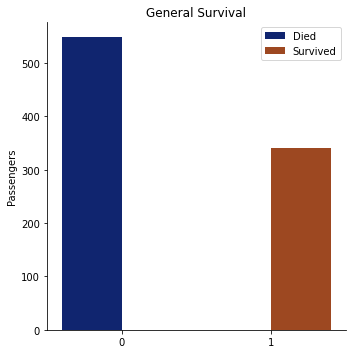

---------------------------------------------------------Survival by Gender----------------------------------------------------------
Males that survived:    109 	 Females that survived:    231 
Rate of male survival: 18.89% 	 Rate of female survival: 74.04%


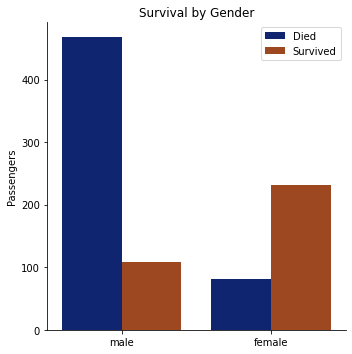

----------------------------------------------------------Survival by Class----------------------------------------------------------
Upper Class that survived:      134 	 Middle Class that survived:      87 	 Lower Class that survived:      119
Rate of Upper Class survival: 62.62% 	 Rate of Middle Class Survival: 47.28% 	 Rate of Middle Class Survival: 24.24%


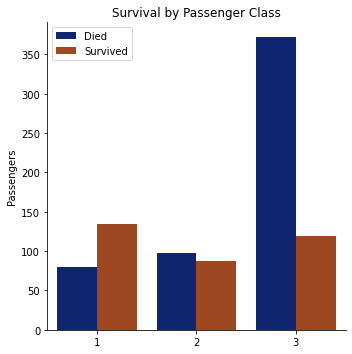

---------------------------------------------------Survival by Port of Embarkation---------------------------------------------------
Cherbourg Port Survival:           93 		 Queenstown Port Survival:           30 	 Southampton Port Survival:      217
Rate of Cherbourg Port survival: 55.36% 	 Rate of Queenstown Port Survival: 38.96% 	 Rate of Southampton Survival: 33.70%


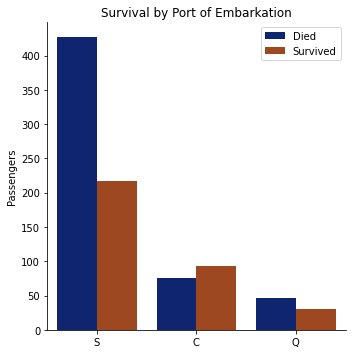

----------------------------------------------------------Survival by Cabin----------------------------------------------------------
Cherbourg Port Survival:           93 		 Queenstown Port Survival:           30 	 Southampton Port Survival:      217
Rate of Cherbourg Port survival: 55.36% 	 Rate of Queenstown Port Survival: 38.96% 	 Rate of Southampton Survival: 33.70%


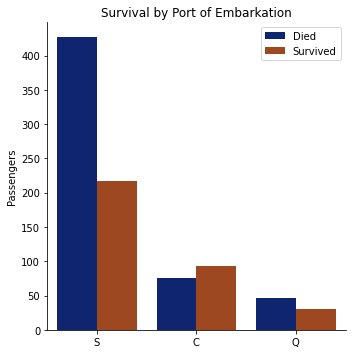

In [16]:
totalSurvived = (train.Survived == 1).sum()
totalDied = (train.Survived == 0).sum()

print('{:-^133}'.format('General Survival'))
print('Total that survived: {} \t Total that did not survive: {} \nRate of survival: {:>8.2%} \t Rate of not survival: {:>11.2%}'.format(totalSurvived,totalDied, totalSurvived/(totalSurvived+totalDied),\
                                                                                                                                           totalDied/(totalSurvived+totalDied)))


sns.catplot(hue="Survived", kind="count", x = "Survived", palette="dark", data=train, legend = False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper right', labels=['Died', 'Survived'])
plt.title('General Survival')
plt.show()

print('{:-^133}'.format('Survival by Gender'))
print('Males that survived: {:>6} \t Females that survived: {:>6} \nRate of male survival: {:.2%} \t Rate of female survival: {:.2%}'.format(legendDict['maleSurvival'],legendDict['femaleSurvival'], \
                                                                                                                   legendDict['maleSurvival']/legendDict['maleTotal'],legendDict['femaleSurvival']/legendDict['femaleTotal']))

sns.catplot(hue="Survived", kind="count", x = "Sex", palette="dark", data=train, legend = False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper right', labels=['Died', 'Survived'])
plt.title('Survival by Gender')
plt.show()


print('{:-^133}'.format('Survival by Class'))
print('Upper Class that survived: {:>8} \t Middle Class that survived: {:>7} \t Lower Class that survived: {:>8}'.format(legendDict['1ClassSurvival'],legendDict['2ClassSurvival'],legendDict['3ClassSurvival']))
print('Rate of Upper Class survival: {:.2%} \t Rate of Middle Class Survival: {:.2%} \t Rate of Middle Class Survival: {:.2%}'.format(legendDict['1ClassSurvival']/legendDict['1ClassTotal'],\
    legendDict['2ClassSurvival']/legendDict['2ClassTotal'],legendDict['3ClassSurvival']/legendDict['3ClassTotal']))
        

sns.catplot(hue="Survived", kind="count", x = "Pclass", palette="dark", data=train,legend=False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper left', labels=['Died', 'Survived'])
plt.title('Survival by Passenger Class')
plt.show()

print('{:-^133}'.format('Survival by Port of Embarkation'))
print('Cherbourg Port Survival: {:>12} \t\t Queenstown Port Survival: {:>12} \t Southampton Port Survival: {:>8}'\
        .format(legendDict['CPortSurvival'],legendDict['QPortSurvival'],legendDict['SPortSurvival']))
print('Rate of Cherbourg Port survival: {:.2%} \t Rate of Queenstown Port Survival: {:.2%} \t Rate of Southampton Survival: {:.2%}'.format(legendDict['CPortSurvival']/legendDict['CPortTotal'],\
    legendDict['QPortSurvival']/legendDict['QPortTotal'],legendDict['SPortSurvival']/legendDict['SPortTotal']))
        

sns.catplot(hue="Survived", kind="count", x = "Embarked", palette="dark", data=train,legend=False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper right', labels=['Died', 'Survived'])
plt.title('Survival by Port of Embarkation')
plt.show()


print('{:-^133}'.format('Survival by Cabin'))
print('Cherbourg Port Survival: {:>12} \t\t Queenstown Port Survival: {:>12} \t Southampton Port Survival: {:>8}'\
        .format(legendDict['CPortSurvival'],legendDict['QPortSurvival'],legendDict['SPortSurvival']))
print('Rate of Cherbourg Port survival: {:.2%} \t Rate of Queenstown Port Survival: {:.2%} \t Rate of Southampton Survival: {:.2%}'.format(legendDict['CPortSurvival']/legendDict['CPortTotal'],\
    legendDict['QPortSurvival']/legendDict['QPortTotal'],legendDict['SPortSurvival']/legendDict['SPortTotal']))
        

sns.catplot(hue="Survived", kind="count", x = "Embarked", palette="dark", data=train,legend=False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper right', labels=['Died', 'Survived'])
plt.title('Survival by Port of Embarkation')
plt.show()

### As we can see, the majority of the females passenger survived, whereas the majority of males died. In the general view, 60% of the people survived. <br>
### Concerning the analysis by classes, we can notice that the higher the class, the higher the survival rate, where the chance of surviving if you are in the first class is more than the double if you were in the third class.<br>
### There is some difference of survival rate between the ports, but not so distributed as the class and gender divisions
### Next we will see the division by Cabin.

Total of people with no Cabin: 687		 Total Survival within no Cabin: 206		 Rate of Survival within no Cabin: 29.99%
Total of people in Cabin C:    59		 Total Survival in Cabin C:       35		 Rate of Survival in Cabin C:      59.32%
Total of people in Cabin E:    32		 Total Survival in Cabin E:       24		 Rate of Survival in Cabin E:      75.00%
Total of people in Cabin G:     4		 Total Survival in Cabin G:        2		 Rate of Survival in Cabin G:      50.00%
Total of people in Cabin D:    33		 Total Survival in Cabin D:       25		 Rate of Survival in Cabin D:      75.76%
Total of people in Cabin A:    15		 Total Survival in Cabin A:        7		 Rate of Survival in Cabin A:      46.67%
Total of people in Cabin B:    45		 Total Survival in Cabin B:       33		 Rate of Survival in Cabin B:      73.33%
Total of people in Cabin F:    13		 Total Survival in Cabin F:        8		 Rate of Survival in Cabin F:      61.54%
Total of people in Cabin T:     1		 Total Survival in Cabin T:        0		 Rate 

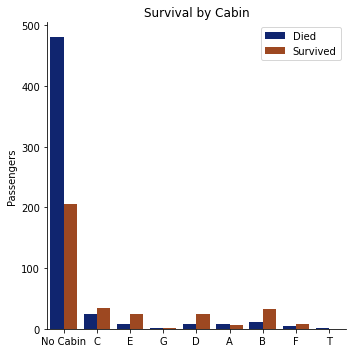

In [17]:
for cabin in train.Cabin.unique():
    totalCabin = (train.Cabin==cabin).sum()
    if cabin == 'No Cabin':
        # print('Total Survival within no Cabin: {}\t\t Rate of Survival within no Cabin: {:.2%}'.format(legendDict['Cabin'+cabin+'Survival'],legendDict['Cabin'+cabin+'Survival']/totalCabin))
        print('Total of people with no Cabin: {}\t\t Total Survival within no Cabin: {}\t\t Rate of Survival within no Cabin: {:.2%}'.format(totalCabin,legendDict['Cabin'+cabin+'Survival'],legendDict['Cabin'+cabin+'Survival']/totalCabin))
    else:
        print('Total of people in Cabin {cabin}: {:>5}\t\t Total Survival in Cabin {cabin}: {:>8}\t\t Rate of Survival in Cabin {cabin}: {:>11.2%}'.format(totalCabin,legendDict['Cabin'+cabin+'Survival'],\
                                                                                                                                                legendDict['Cabin'+cabin+'Survival']/totalCabin,cabin=cabin))
        

sns.catplot(hue="Survived", kind="count", x = "Cabin", palette="dark", data=train,legend=False).set(xlabel=None, ylabel = 'Passengers')
plt.legend( loc='upper right', labels=['Died', 'Survived'])
plt.title('Survival by Cabin')
plt.show()

### From what we can see, people who were in any cabin, excluding cabin A and T, had 50% or more chance of surviving.<br> The people with no cabin had the least change of survival (the T cabin is not considered because the small sample size)

# Starting the Machine Learning Model

### As we have a ratio of 60/40 of the possibles output, we will start the analysis without any adjustment in the set and see how it will behave
### First, we need to address the problem of categorical columns. We will use the One Hot Encoder preprocessing tool

In [18]:
print(train.select_dtypes('object').columns)

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'], dtype='object')


### We don't need the Name and Ticket columns for our analysis, so we are going to just drop them

In [19]:
train.drop(['Name','Ticket'],axis=1,inplace=True)
test.drop(['Name','Ticket'],axis=1,inplace=True)

### The test dataset has no column "Survived", so we cannot test the accuracy of our model. The solution will be spliting the train dataset into train and test dataset, that we will name it with the prefix val (from validation dataset)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

y = train.Survived
X = train.drop('Survived',axis=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

labelCol = list(train.select_dtypes('object').columns)

OHEncoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

OHTrainCols = pd.DataFrame(OHEncoder.fit_transform(train_X[labelCol]))
OhTestCols = pd.DataFrame(OHEncoder.transform(val_X[labelCol]))

OHTrainCols.index = train_X.index
OhTestCols.index = val_X.index

train_X.drop(labelCol,axis=1,inplace=True)
val_X.drop(labelCol,axis=1,inplace=True)

train_X = pd.concat([train_X,OHTrainCols],axis=1)
val_X = pd.concat([val_X,OhTestCols],axis=1)

print(train_X.head())
print(val_X.head())

             Pclass       Age  SibSp  Parch      Fare    0    1    2    3    4  ...    8    9   10   11   12   13   14   15   16   17
PassengerId                                                                     ...                                                  
319               1  31.00000      0      2  164.8667  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
706               2  39.00000      0      0   26.0000  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
348               3  25.14062      1      0   16.1000  1.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
491               3  25.14062      1      0   19.9667  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
442               3  20.00000      0      0    9.5000  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0

[5 rows x 23 columns]
             Pclass       Age  SibSp  P

### The one-hot-encoding method has added 18-4 = 14 columns (2 columns for sex, 8 columns for cabin, 3 columns for embarked and 5 columns for title. The original columns were removed, hence 18-4 new columns)
### Now there is only left numerical columns we can start using the ML models in our data. For the first try we will use the Extreme Randomized Tree and won't change any parameter

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=0)
model.fit(train_X.values,train_y)

pred = model.predict(val_X.values)


### Now with the prediction of the results for the validation X values, we can import the confusion matrix and see how well the model did.

In [22]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precETC = tp/(tp+fp)
recETC = tp/(tp+fn)
accETC = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accETC,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precETC,recETC))
print('F-score: {:>25.2f}'.format((2*precETC*recETC)/(precETC+recETC)))


Number of correct prediction: 180	 Accuracy:       80.72%
True negative:                113	 False positive:  19
False negative:                24	 True positive:   67
Precision:                    0.78	 Recall:         0.74
F-score:                      0.76


### We have reached 80.72% of correct predictions. Now we will change the number of trees of the model to see if we can have a better result

In [23]:
resultsEst = []
def nmodel(n):
    model = ExtraTreesClassifier(random_state=0,n_estimators=n)
    model.fit(train_X.values,train_y)
    pred = model.predict(val_X.values)
    tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
    print('Number of estimators: {}\tNumber of correct prediction: {}\tAccuracy: {:.2%}'.format(n,tn+tp,(tn+tp)/len(val_y)))
    resultsEst.append([n,(tp+tn)/len(val_y)])

narray = [100,200,300,400,500,1000]

for n in narray:
    nmodel(n)

bstRatio = max(map(lambda x: x[1], resultsEst))

for item in resultsEst:
    if item[1] == bstRatio:
        nEst=(item[0])
        break
    
print('\nBest ratio : {:.2%} with {} estimators'.format(bstRatio,nEst))

Number of estimators: 100	Number of correct prediction: 180	Accuracy: 80.72%
Number of estimators: 200	Number of correct prediction: 181	Accuracy: 81.17%
Number of estimators: 300	Number of correct prediction: 181	Accuracy: 81.17%
Number of estimators: 400	Number of correct prediction: 180	Accuracy: 80.72%
Number of estimators: 500	Number of correct prediction: 180	Accuracy: 80.72%
Number of estimators: 1000	Number of correct prediction: 181	Accuracy: 81.17%

Best ratio : 81.17% with 200 estimators


### From the test, we can see that we had just little improvement, when we change the number of estimators from 100 (default) to 200, for example. But we can see as well that a higher number of trees does not necessarily means better ratio (e.g. 400 estimators yield 80.72%, less than 200 estimators, with 81.17% accuracy)
### Now let's try tuning the number of features parameter. The default is square root of the number of features, in our cause, sqrt(23), between 4 and 5 features.
### We will test from 1 feature to 23 features, the max, incrementing in steps of 1

In [24]:
resultsFeat = []
def nmodel(i):
    model = ExtraTreesClassifier(random_state=0,max_features=i)
    model.fit(train_X.values,train_y)
    pred = model.predict(val_X.values)
    tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
    print('Number of features: {}\tNumber of correct prediction: {}\tAccuracy: {:.2%}'.format(i,tn+tp,(tn+tp)/len(val_y)))
    resultsFeat.append([i,(tp+tn)/len(val_y)])


for i in range(1,24):
    nmodel(i)

bstRatio = max(map(lambda x: x[1], resultsFeat))

for item in resultsFeat:
    if item[1] == bstRatio:
        nFeat=(item[0])
        break
    
print('\nBest ratio : {:.2%} with {} features'.format(bstRatio,nFeat))

Number of features: 1	Number of correct prediction: 180	Accuracy: 80.72%
Number of features: 2	Number of correct prediction: 182	Accuracy: 81.61%
Number of features: 3	Number of correct prediction: 184	Accuracy: 82.51%
Number of features: 4	Number of correct prediction: 180	Accuracy: 80.72%
Number of features: 5	Number of correct prediction: 184	Accuracy: 82.51%
Number of features: 6	Number of correct prediction: 183	Accuracy: 82.06%
Number of features: 7	Number of correct prediction: 179	Accuracy: 80.27%
Number of features: 8	Number of correct prediction: 176	Accuracy: 78.92%
Number of features: 9	Number of correct prediction: 180	Accuracy: 80.72%
Number of features: 10	Number of correct prediction: 180	Accuracy: 80.72%
Number of features: 11	Number of correct prediction: 177	Accuracy: 79.37%
Number of features: 12	Number of correct prediction: 182	Accuracy: 81.61%
Number of features: 13	Number of correct prediction: 178	Accuracy: 79.82%
Number of features: 14	Number of correct predic

### We can plot this information in a bar chart, so we can see better the variation between the number of features

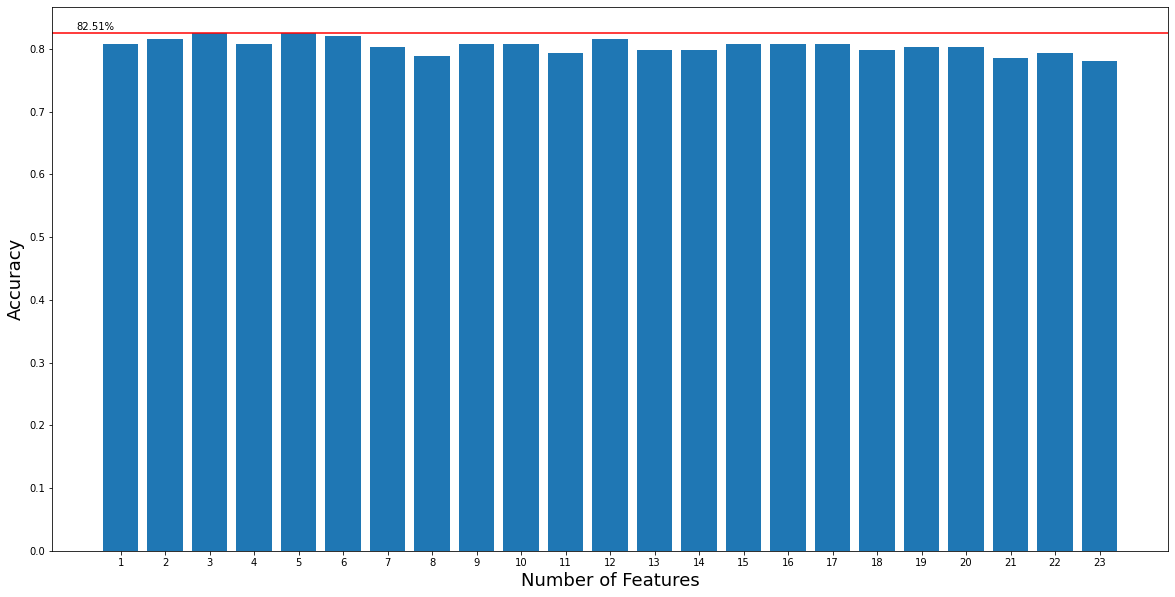

In [25]:
resultsFeatX = list(map(lambda x: x[0],resultsFeat))
resultsFeatY= list(map(lambda x: x[1],resultsFeat))

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(resultsFeatX,resultsFeatY)
ax.set_xticks([*resultsFeatX])
ax.set_xlabel('Number of Features',fontsize = 18)
ax.set_ylabel('Accuracy',fontsize = 18)
plt.axhline(y=bstRatio,color='r')
plt.text(0,bstRatio+0.005,str('{:.2%}'.format(bstRatio)))

plt.show()

### From the table, we notice that our default model was using 4 features (80.72%). But we could achieve a better ratio using less features, namely, only 3. Note as well, that sometimes a higher number of features can lower our accuracy ratio
### Now that we have chosen the best number of estimators and features, we are going to combine them and see the results

In [26]:
model = ExtraTreesClassifier(random_state=0,max_features=nFeat,n_estimators=nEst)

model.fit(train_X.values,train_y)
pred = model.predict(val_X.values)
tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precETCOp = tp/(tp+fp)
recETCOp = tp/(tp+fn)
accETCOp = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accETCOp,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precETCOp,recETCOp))
print('F-score: {:>25.2f}'.format((2*precETCOp*recETCOp)/(precETCOp+recETCOp)))

Number of correct prediction: 182	 Accuracy:       81.61%
True negative:                114	 False positive:  18
False negative:                23	 True positive:   68
Precision:                    0.79	 Recall:         0.75
F-score:                      0.77


### The combination of the best numbers from each parameter did not yield the best result when used together. Using 3 features with 100 estimators (the default) has produced a better prediction than with 200 estimators
### So we are creating a model with only 3 features and 100 estimators

In [27]:
model = ExtraTreesClassifier(random_state=0,max_features=nFeat,n_estimators=100)

model.fit(train_X.values,train_y)
pred = model.predict(val_X.values)
tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precETCOp = tp/(tp+fp)
recETCOp = tp/(tp+fn)
accETCOp = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accETCOp,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precETCOp,recETCOp))
print('F-score: {:>25.2f}'.format((2*precETCOp*recETCOp)/(precETCOp+recETCOp)))

Number of correct prediction: 184	 Accuracy:       82.51%
True negative:                114	 False positive:  18
False negative:                21	 True positive:   70
Precision:                    0.80	 Recall:         0.77
F-score:                      0.78


### Now let's apply the oversampling technique, in order to balance the data, making the survival/non-survival rate as 50/50
### We will increase the number of survival outputs

In [28]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(train_X.values,train_y)

print('{:-^60}'.format('Before oversampling'))
print('Number of survival: {} \t Number of non-survival: {}'.format((train_y==1).sum(),(train_y==0).sum()))
print('\n{:-^60}'.format('After oversampling'))
print('Number of survival: {} \t Number of non-survival: {}'.format((y_resampled==1).sum(),(y_resampled==0).sum()))

--------------------Before oversampling---------------------
Number of survival: 249 	 Number of non-survival: 417

---------------------After oversampling---------------------
Number of survival: 417 	 Number of non-survival: 417


### Let's test it again, using our best parameter untill now, number of features = 3 and estimators = 100 (default)

In [29]:
model = ExtraTreesClassifier(random_state=0,max_features=nFeat)
model.fit(X_resampled,y_resampled)

pred = model.predict(val_X.values)
tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precETCResam = tp/(tp+fp)
recETCResam = tp/(tp+fn)
accETCResam = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accETCResam,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precETCResam,recETCResam))
print('F-score: {:>25.2f}'.format((2*precETCResam*recETCResam)/(precETCResam+recETCResam)))

Number of correct prediction: 179	 Accuracy:       80.27%
True negative:                113	 False positive:  19
False negative:                25	 True positive:   66
Precision:                    0.78	 Recall:         0.73
F-score:                      0.75


### There is little to almost no change. That is because the data was only slightly imbalanced. We will test other models now, with the original dataset and with no change in the parameters

## Starting with the Gaussian Naive Bayes model

In [30]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(train_X.values, train_y)
pred = gnb.predict(val_X.values)

tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precGNB = tp/(tp+fp)
recGNB = tp/(tp+fn)
accGNB = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accGNB,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precGNB,recGNB))
print('F-score: {:>25.2f}'.format((2*precGNB*recGNB)/(precGNB+recGNB)))

Number of correct prediction: 168	 Accuracy:       75.34%
True negative:                 94	 False positive:  38
False negative:                17	 True positive:   74
Precision:                    0.66	 Recall:         0.81
F-score:                      0.73


### The Gaussian Naive Bayes model had a lower accuracy and precision, but had a higher recall

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,max_iter=1000).fit(train_X.values, train_y)
pred = clf.predict(val_X.values)
tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precCLF = tp/(tp+fp)
recCLF = tp/(tp+fn)
accCLF = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accCLF,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precCLF,recCLF))
print('F-score: {:>25.2f}'.format((2*precCLF*recCLF)/(precCLF+recCLF)))

Number of correct prediction: 174	 Accuracy:       78.03%
True negative:                107	 False positive:  25
False negative:                24	 True positive:   67
Precision:                    0.73	 Recall:         0.74
F-score:                      0.73


### The Logistic Regression had a lower accuracy, but the levels are precision and recall are balanced

In [32]:
from sklearn.neighbors import KNeighborsClassifier

kmodel = KNeighborsClassifier(n_neighbors=3)

kmodel.fit(train_X.values,train_y)
pred = kmodel.predict(val_X.values)
tn, fp, fn, tp = confusion_matrix(val_y,pred).ravel()
precKN = tp/(tp+fp)
recKN = tp/(tp+fn)
accKN = (tp+tn)/len(val_y)
print('Number of correct prediction: {}\t Accuracy: {:>12.2%}\nTrue negative: {:>18}\t False positive: {:>3}\nFalse negative: {:>17}\t True positive: {:>4}'.format(tn+tp,accKN,tn,fp,fn,tp))
print('Precision: {:>23.2f}\t Recall: {:>12.2f}'.format(precKN,recKN))
print('F-score: {:>25.2f}'.format((2*precKN*recKN)/(precKN+recKN)))

Number of correct prediction: 161	 Accuracy:       72.20%
True negative:                106	 False positive:  26
False negative:                36	 True positive:   55
Precision:                    0.68	 Recall:         0.60
F-score:                      0.64


### The Kneighbors had the worst accuracy and F-score overall

### Let us plot the different accuracies between models

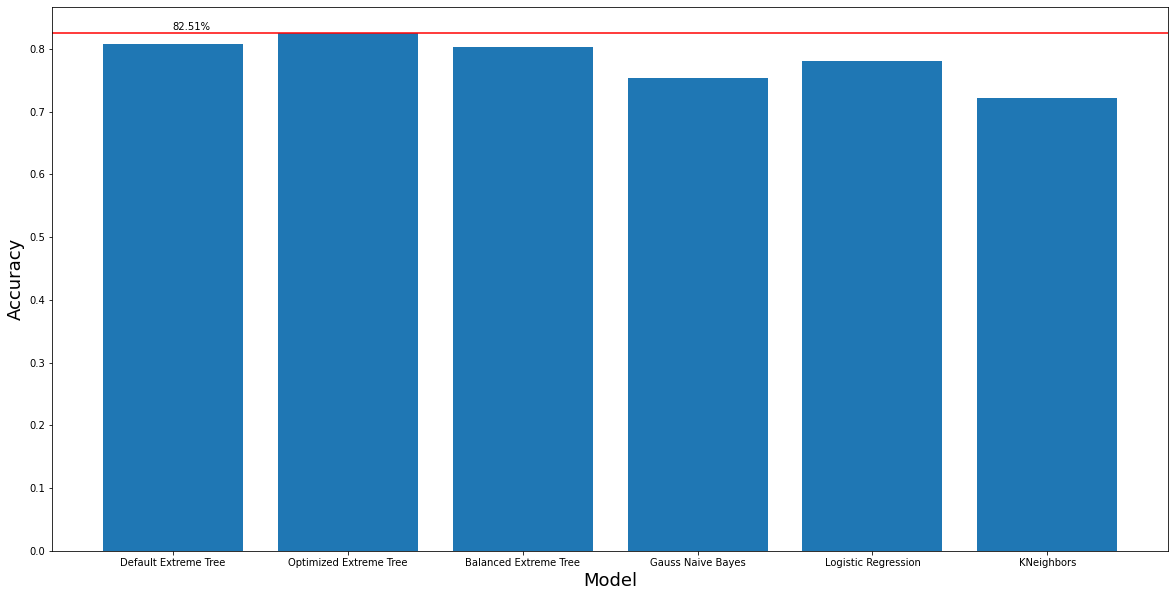

In [33]:
results = pd.Series(data=[accETC,accETCOp,accETCResam,accGNB,accCLF,accKN],index=['Default Extreme Tree','Optimized Extreme Tree','Balanced Extreme Tree','Gauss Naive Bayes','Logistic Regression','KNeighbors'])

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(results.index,results.values)

ax.set_xlabel('Model',fontsize = 18)
ax.set_ylabel('Accuracy',fontsize = 18)
plt.axhline(y=max(results.values),color='r')
plt.text(0,max(results.values)+0.005,str('{:.2%}'.format(max(results.values))))

plt.show()

### From the chart, we can conclude that the best model was the optimized extreme tree, where we had the extremely randomized tree as model and the number of features parameter was set to 3.
### This is only taking the accuracy into account. We could choose our model based on the best precision, recall or F-score as well, taking into account what is the most important parameter for us.

### We can use now our chosen model to predict the test dataset and then send the results to Kaggle
### First we just need to adjust the test dataset with the One Hot Encoding procedure we did before for our own test dataset and then we can evaluate it

In [34]:
OHCols = pd.DataFrame(OHEncoder.fit_transform(test[labelCol]))

OHCols.index = test.index

test.drop(labelCol,axis=1,inplace=True)

test = pd.concat([test,OHCols],axis=1)

print(test.head())

             Pclass   Age  SibSp  Parch     Fare    0    1    2    3    4  ...    8    9   10   11   12   13   14   15   16   17
PassengerId                                                                ...                                                  
892               3  34.5      0      0   7.8292  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
893               3  47.0      1      0   7.0000  1.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
894               2  62.0      0      0   9.6875  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
895               3  27.0      0      0   8.6625  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
896               3  22.0      1      1  12.2875  1.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0

[5 rows x 23 columns]


### We can then make a prediction on the test dataset, make it into a Dataframe and then save it as csv, so we can submit the file.
### The format of the csv is: PassengerId and Survived

In [35]:
model = ExtraTreesClassifier(random_state=0,max_features=nFeat,n_estimators=100)

model.fit(train_X.values,train_y)
pred = model.predict(test.values)

test_df = pd.DataFrame(data=[test.index,pred],index=['PassengerId','Survived'])
test_df = test_df.T
print(test_df)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         1
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


In [36]:
test_df.to_csv('submission.csv',index=False)